This notebook will show how to deal with imbalance problems.

# 1. Set up

# 2. Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.metrics import classification_report_imbalanced

# 3. Define global variables

In [2]:
INPUT_PATH = "../data/credit_card_data/creditcard.csv"

# 4. Functions

# 5. Code

We are going to work with an imbalance problem in order to see how imbalance is such a common problem and what can we do in order to solve it and make a good predictive model.

First of all, we need to load some data. We are going to use the credit card fraud dataset that can be found in *kaggle*, https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download

In [3]:
data = pd.read_csv(INPUT_PATH)

data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


This time we are not going to focus on the variables and so on because the main goal here is to see the imbalance problem and how to solve it. 

Let's see then if the problem is imbalanced:

In [4]:
class_counts = pd.DataFrame(data["Class"].value_counts(normalize=True))

class_counts

,Class
0,0.998273
1,0.001727


If we show it in a plot:

(0.0, 1.1)

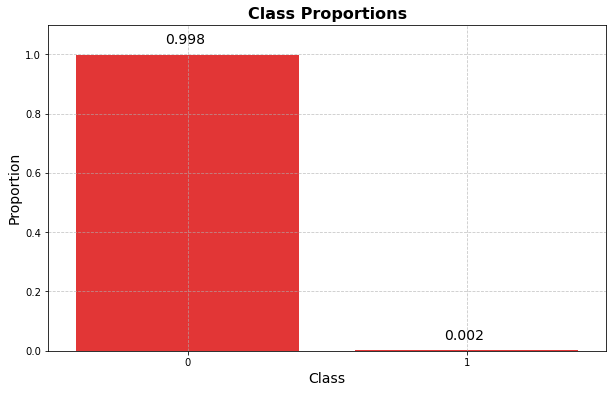

In [5]:
plt.figure(figsize=(10, 6)) 

# Barplot
ax = sns.barplot(x=class_counts.index, y='Class', data=class_counts, color="red",alpha=0.9)

# Indicate the proportion over the bars
for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 3)}', 
                # We need to set the numbers in the middle of each bar
                (p.get_x() + p.get_width()/2.5, p.get_height()+0.02), 
                fontsize=14,  
                xytext=(0, 5), 
                textcoords='offset points')

# Title and axis
plt.title('Class Proportions', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

# Set the grid
plt.grid(True, linestyle='--', alpha=0.7)

# Set the y limit to 1.1 in order to see better the numbers over the bar
plt.ylim(0, 1.1)

Clearly, the imbalance can be seen as the positive class is very little compared to the negative class.

## 5.1. Baseline

Now we are going to make a simple model, without touching any configuration nor any data processing. The model will be a bad model due to the imbalance problem. We are going to see what problems can be faced when dealing with this situation

First, train test split:

In [6]:
X = data.drop("Class", axis=1)
y = data["Class"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

We will train a logistic regression:

In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [9]:
y_pred = model.predict(X_test)

<AxesSubplot:>

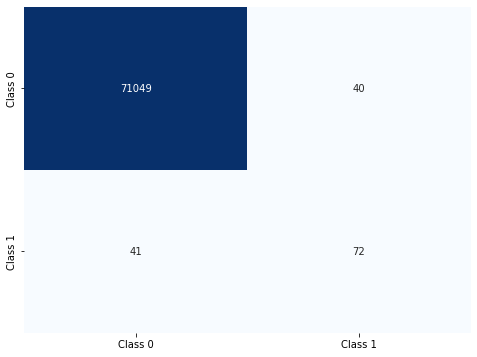

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], cbar=False)

In [11]:
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Accuracy Score: 0.9988623915058565
